In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta, binom, betabinom, chi2
import arviz as az

In [14]:
n = 9
x = 6
a = 2
b = 2

a_posterior = a+x
b_posterior = b+n-x

## Using the exact theoretical Bayesian model

In [15]:
theta_grid = np.linspace(0, 1, num=200)
x_grid     = np.arange(0, 10)
likelihood = beta.pdf(theta_grid, x+1, n-x+1)
prior      = beta.pdf(theta_grid, a, b)
posterior  = beta.pdf(theta_grid, a_posterior, b_posterior)

posterior_approx = prior * likelihood

Plot the (exact) prior, likelihood and posterior

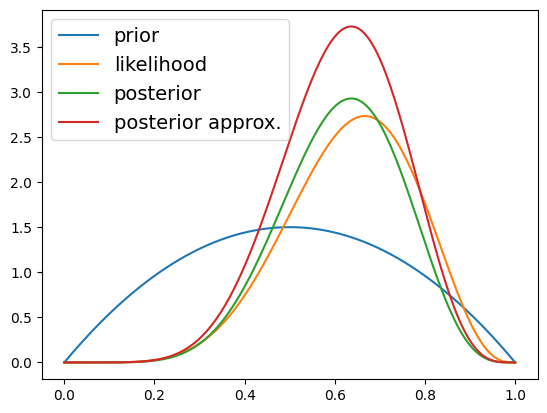

In [16]:
#plt.figure(figsize=(12,10))
plt.plot(theta_grid, prior, label='prior')
plt.plot(theta_grid, likelihood, label='likelihood')
plt.plot(theta_grid, posterior, label='posterior')
plt.plot(theta_grid, posterior_approx, label='posterior approx.')
plt.legend(fontsize=14)

Plot the (exact) previous and posterior predictives

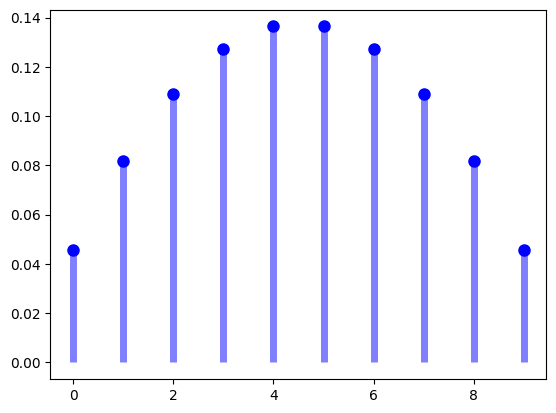

In [17]:
fig, ax = plt.subplots(1, 1) #figsize=(12,10)
ax.plot(x_grid, betabinom.pmf(x_grid, n, a, b), 'bo', ms=8)
ax.vlines(x_grid, 0, betabinom.pmf(x_grid, n, a, b), colors='b', lw=5, alpha=0.5)

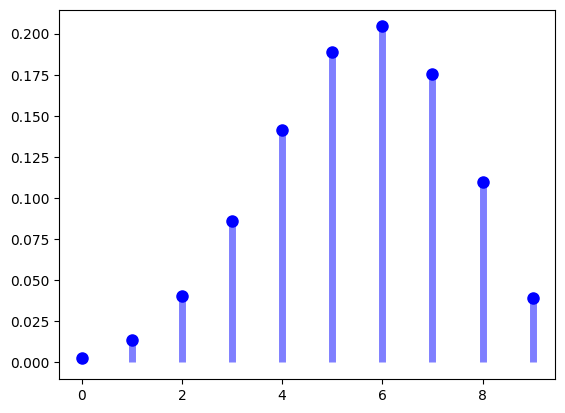

In [18]:
fig, ax = plt.subplots(1, 1) #figsize=(12,10)
ax.plot(x_grid, betabinom.pmf(x_grid, n, a_posterior, b_posterior), 'bo', ms=8)
ax.vlines(x_grid, 0, betabinom.pmf(x_grid, n, a_posterior, b_posterior), colors='b', lw=5, alpha=0.5)

## Simulate from the posterior and from the posterior predictive

### Simulate from the posterior

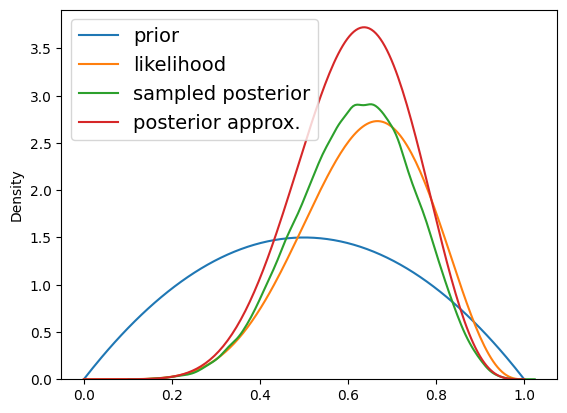

In [20]:
n_sample = 10**5
posterior_sample = random.choices(theta_grid, weights=posterior_approx, k=n_sample)

plt.plot(theta_grid, prior, label='prior')
plt.plot(theta_grid, likelihood, label='likelihood')
sns.kdeplot(posterior_sample, label='sampled posterior')
plt.plot(theta_grid, posterior_approx, label='posterior approx.')
plt.legend(fontsize=14)

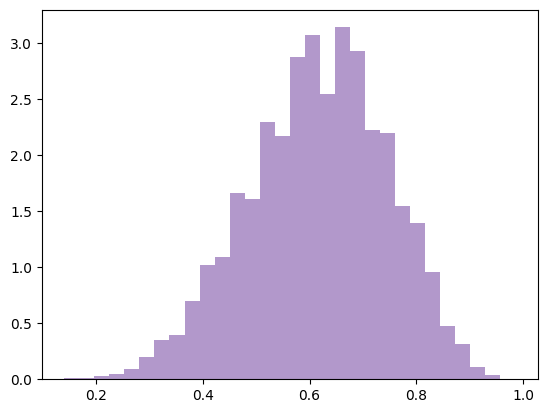

In [21]:
hist = plt.hist(posterior_sample, bins=30, density=True, color='RebeccaPurple', alpha=0.5)

We normalized the posterior sample, so in the MAP it has a value of one.

<BarContainer object of 30 artists>

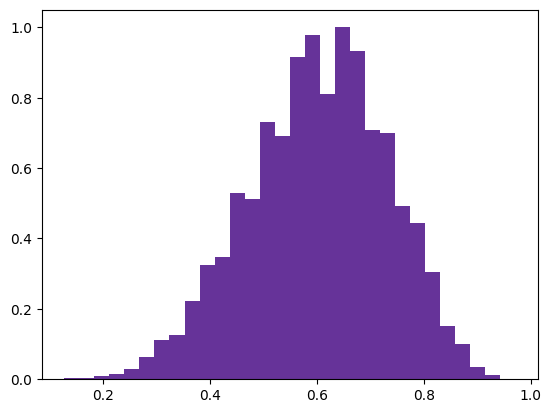

In [22]:
width = (np.diff(hist[1]))[0]
middle_points = hist[1][:-1]
normalized_heights = hist[0] / hist[0].max()
plt.bar(middle_points, normalized_heights, width, color='RebeccaPurple')

Using the normal approximation to get an interval of $(1-\alpha)\times 100\%$ of posterior probability.

In [23]:
alpha = 0.156
point_cut = np.exp(-0.5 * chi2.ppf(1-alpha, 1))
extreme_points = middle_points[normalized_heights >= point_cut][[0,-1]]

extreme_points

array([0.45025126, 0.7879397 ])

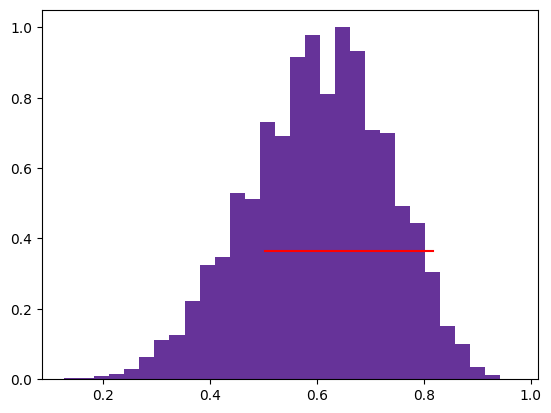

In [24]:
plt.bar(middle_points, normalized_heights, width, color='RebeccaPurple')
plt.axhline(point_cut, extreme_points[0], extreme_points[1], color='r')

### Simulate from the posterior predictive

<AxesSubplot:ylabel='Probability'>

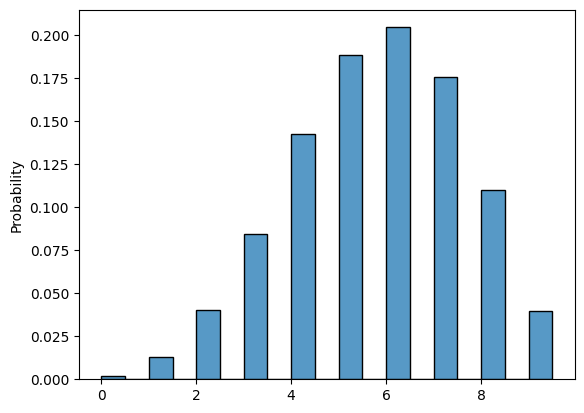

In [25]:
posterior_predictive = binom.rvs(size=n_sample, n=9, p=posterior_sample)
sns.histplot(posterior_predictive, stat='probability', bins=np.arange(0,10,0.5))

## Punctual estimation

In [28]:
posterior_sample = pd.Series(posterior_sample)

### MAP (Maximum a posteriori) $\frac{\alpha-1}{\alpha+\beta-2}$

In [29]:
print('Theoretical MAP: ', (a_posterior-1) / (a_posterior+b_posterior-2))
print('Mode from posterior sample: ', posterior_sample.mode().values[0])

Theoretical MAP:  0.6363636363636364
Mode from posteior sample:  0.6130653266331658


### Posterior mean $\frac{\alpha}{\alpha+\beta}$

In [30]:
print('Theoretical mean a posteriori: ', (a_posterior) / (a_posterior+b_posterior))
print('Mean from posterior sample: ', posterior_sample.mean())

Theoretical mean a posteriori:  0.6153846153846154
Mean from posteior sample:  0.6158293969849246


### Posterior median $\approx \frac{\alpha-1/3}{\alpha+\beta-2/3}$

In [31]:
print('Approx. median a posteriori: ', (a_posterior-1/3) / (a_posterior+b_posterior-2/3))
print('Median from posterior sample: ', posterior_sample.median())

Approx. median a posteriori:  0.6216216216216216
Mode from posteior sample:  0.6231155778894473


### Using loss functions

In [32]:
def quadratic_loss(p):
    return(sum(posterior_approx*1/2*(p-theta_grid)**2))

In [33]:
approx_quad_loss = np.array([quadratic_loss(p) for p in theta_grid])
theta_grid[approx_quad_loss.argmin()]

0.6130653266331658

In [34]:
def absolute_loss(p):
    return(sum(posterior_approx*abs(p-theta_grid)))

In [35]:
approx_abs_loss = np.array([absolute_loss(p) for p in theta_grid])
theta_grid[approx_abs_loss.argmin()]

0.6231155778894473

In [36]:
def huber_loss(p, delta=1):
    aux = np.where(np.abs(p-theta_grid) < delta, 1/2*(p-theta_grid)**2 , delta*(np.abs(p-theta_grid)-1/2*delta))
    return(sum(aux))

In [37]:
approx_huber_loss = np.array([huber_loss(p) for p in theta_grid])
theta_grid[approx_huber_loss.argmin()]

0.49748743718592964

## Interval estimation

### Credible interval or compatibility interval

Using the normal approximation

In [38]:
alpha = 0.16
point_cut = np.exp(-0.5 * chi2.ppf(1-alpha, 1))
extreme_points = middle_points[normalized_heights >= point_cut][[0,-1]]

extreme_points

array([0.45025126, 0.7879397 ])

Using the theoretical exact posterior

In [ ]:
print(beta.ppf(alpha/2, a_posterior, b_posterior), beta.ppf(1-alpha/2, a_posterior, b_posterior))

Using quantile intervals

In [39]:
print(posterior_sample.quantile(alpha/2), posterior_sample.quantile(1-alpha/2))

0.42378508142729054 0.7945639785994926
0.4221105527638191 0.7939698492462312


### Highest posterior density interval (HPDI)

In [40]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=1-alpha)

array([0.42211055, 0.78894472])

## Hypothesis test

$\theta \geq 0.5$

In [41]:
sum(posterior_sample >= 0.5) / n_sample

0.80643

$\theta \geq 0.9$

In [42]:
sum(posterior_sample >= 0.9) / n_sample

0.00406